In [1548]:
from binance.client import Client
import pandas as pd
import numpy as np
import statsmodels.api as sm
from itertools import combinations
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, cross, resample_apply, plot_heatmaps
from skopt.plots import plot_objective
import scipy.optimize as spopt
from pykalman import KalmanFilter
import seaborn as sns
import matplotlib.pyplot as plt

In [1549]:
"""

"""

'\n\n'

In [1550]:
# DATA LOAD AND PROCESSING

In [1551]:
# api_key = 'Vaw3es8Jm2QxdzEtUk8lT1WevjJ2XwXSIBVMV02dOTUpr1BF2FZwjruBrcpgJ9MP'
# api_secret = 'ufGlQKC8t3VxlMqG1X5EmAbNob4cTKMBTjF0ihZQ5avE5EZm6YBWcOzHIUCyNRMx'

In [1552]:
api_key = 'knlZCBMnLPX0S2HQrn8hZDeQseyvjcGqSLzhnCbuVbiFj6VZNXvpD9snD7P2kc9I'
api_secret = 'aMdB68Omz8RGW8tdlW2AIg2GFzVDmL5bkMhhcvernn6YikJZlSs62kLTB3ZP10oU'

In [1553]:
client = Client(api_key, api_secret)

In [1554]:
# List of pairs quoted in Tether
symbols = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT']

In [1555]:
# Pairs' combination for Correlation and Coinegration analysis
pairs = list(combinations(symbols, 2))

In [1556]:
#pairs

In [1557]:
def generate_cross_pairs(symbols, base_symbol='BTC'):
    """
    Generate cross pairs quoted in the base symbol.
    """
    cross_pairs = [symbol.replace('USDT', 'BTC') for symbol in symbols[1:]]
    return cross_pairs

In [1558]:
def split_pair(pair, quote_currency):
    return [pair[:3] + quote_currency, pair[3:] + quote_currency]

In [1559]:
cross_pairs = generate_cross_pairs(symbols)

In [1560]:
#cross_pairs

In [1561]:
interval = Client.KLINE_INTERVAL_15MINUTE
start_date = '2023-01-01'
end_date = '2023-01-31'

In [1562]:
def load_data(symbol, interval, start_date, end_date):
    """
    Load OHLCV MD for a symbol
    """
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades',
               'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df = pd.DataFrame(klines, columns=columns)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df.set_index('timestamp', inplace=True)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    return df

In [1563]:
def load_data_for_symbols(symbols, interval, start_date, end_date):
    """
    Load OHLCV MD for a symbols batch
    """
    data = {}
    for symbol in symbols:
        df = load_data(symbol, interval, start_date, end_date)
        data[symbol] = df
    return data

In [1564]:
symbols_df = load_data_for_symbols(symbols, interval, start_date, end_date)

In [1565]:
print(symbols_df.keys())

dict_keys(['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT'])


In [1566]:
#print(symbols_df.items())

In [1567]:
print(symbols_df['ETHUSDT'].head(1))

               Open     High      Low    Close     Volume
timestamp                                                
2023-01-01  1196.13  1196.69  1194.55  1194.55  1245.8855


In [1568]:
# CROSS PAIRS ANALYSIS

In [1569]:
xsymbols_df = load_data_for_symbols(cross_pairs, interval, start_date, end_date)

In [1570]:
# Cross pair to be analysed 

In [1571]:
#########################################################################################

In [1572]:
symbol = 'ETHBTC'

In [1573]:
split_pairs = split_pair(symbol, 'USDT')

In [1574]:
symbols_df = load_data_for_symbols(split_pairs, interval, start_date, end_date)

In [1575]:
#symbols_df

In [1576]:
df = xsymbols_df[symbol]

In [1577]:
#df.info()

In [1578]:
df.head(1)

,Open,High,Low,Close,Volume
timestamp,,,,,
2023-01-01,0.072299,0.072356,0.072299,0.072306,495.7506


In [1579]:
#symbols_df

In [1580]:
df_base = symbols_df[split_pairs[0]]

In [1581]:
df_base.head(1)

,Open,High,Low,Close,Volume
timestamp,,,,,
2023-01-01,1196.13,1196.69,1194.55,1194.55,1245.8855


In [1582]:
df_quote = symbols_df[split_pairs[1]]

In [1583]:
def plot_series_pair(df_base, df_quote):
    fig, ax1 = plt.subplots()
    plt.figure(figsize=(8, 8))
    # Plot the first column on the primary axis
    ax1.plot(df_base, color='blue', label='BaseValue')
    ax1.set_ylabel('BaseValue')
    
    # Create a secondary axis sharing the same x-axis
    ax2 = ax1.twinx()
    
    # Plot the second column on the secondary axis
    ax2.plot(df_quote, color='red', label='QuotelValue')
    ax2.set_ylabel('QuotelValue')
    
    # Add legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    plt.show()

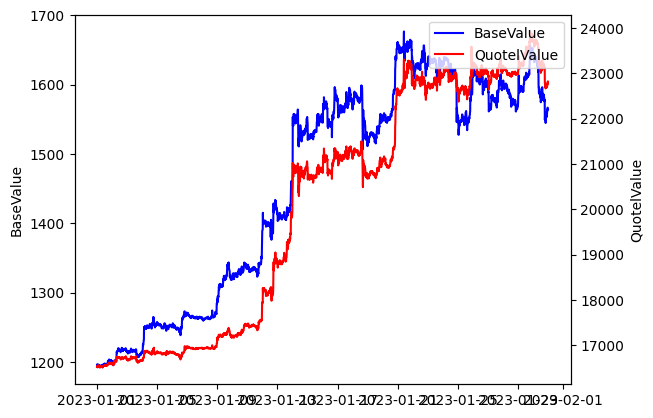

<Figure size 800x800 with 0 Axes>

In [1584]:
plot_series_pair(df_base['Close'], df_quote['Close'])

In [1585]:
enable_echo = True

In [1586]:
def log(*args, **kwargs):
    if enable_echo:
        print(*args, **kwargs)

In [1587]:
def calculate_atr(df, window=14, inperc=False):
    """
    ATR Indicator
    """
    df['High-Low'] = df['High'] - df['Low']
    df['High-PreviousClose'] = np.abs(df['High'] - df['Close'].shift(1))
    df['Low-PreviousClose'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TrueRange'] = np.max([df['High-Low'], df['High-PreviousClose'], df['Low-PreviousClose']], axis=0)
    df['ATR'] = df['TrueRange'].rolling(window=window).mean()
    if inperc:
        df['ATR'] = df['ATR'] / df['Close'].shift(1)
    return df

In [1588]:
# Analysis of ATR dsitribution to assess volatility (timeframe of the OHLC data)

In [1589]:
atr_period = 12

In [1590]:
df_with_atr = df.copy()

In [1591]:
df_with_atr = calculate_atr(df_with_atr, atr_period, True)

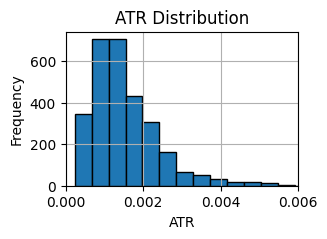

In [1592]:
# Plot histogram of ATR
plt.figure(figsize=(3, 2))
plt.hist(df_with_atr['ATR'], bins=20, edgecolor='black')
plt.xlabel('ATR')
plt.ylabel('Frequency')
plt.title('ATR Distribution')
plt.xlim(0, 0.006)
plt.grid(True)
plt.show()

In [1593]:
df.head(3)

,Open,High,Low,Close,Volume
timestamp,,,,,
2023-01-01 00:00:00,0.072299,0.072356,0.072299,0.072306,495.7506
2023-01-01 00:15:00,0.072306,0.072335,0.072276,0.072328,496.2642
2023-01-01 00:30:00,0.072328,0.072331,0.072247,0.072272,635.8680


In [1594]:
# Trading system's logic (backtesting.py package)
# https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest

In [1595]:
# APPROACH 1
# LINEAR REGRESSION COINTEGRATION MODEL

In [1596]:
def linear_regression(df_base, df_quote):
    y = df_base
    x_const = sm.add_constant(df_quote)
    linear_reg = sm.OLS(y, x_const)
    return linear_reg.fit() 

In [1597]:
lin_regression = linear_regression(df_base['Close'], df_quote['Close'])

In [1598]:
#lin_regression.summary()

In [1599]:
lin_regression.params

const    282.495777
Close      0.058577
dtype: float64

In [1600]:
a = lin_regression.params.iloc[0]
b = lin_regression.params.iloc[1]

In [1601]:
y_pred = a + df_quote['Close'] * b

In [1602]:
#y_pred

Text(0, 0.5, 'ETHUSDT')

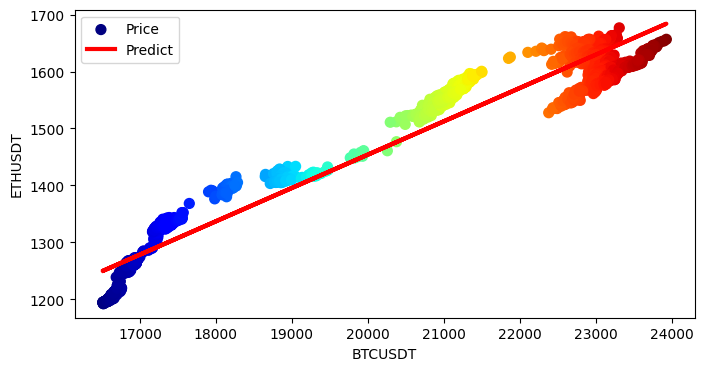

In [1603]:
plt.figure(figsize =(8,4))
cm = plt.get_cmap('jet')
sc = plt.scatter(df_quote['Close'], df_base['Close'], s=50, cmap=cm, c=df_quote['Close'], label='Price')
plt.plot(df_quote['Close'], y_pred, '-', c='red', linewidth=3, label='Predict')
plt.legend()
plt.xlabel(symbols[0])
plt.ylabel(symbols[1])

In [1604]:
# Synthetic cross rate
cross_df = pd.DataFrame(y_pred / df_quote['Close'],df_quote.index)
cross_df.columns = ['PredictedXrate']

Text(0, 0.5, 'Predicted Cross rate')

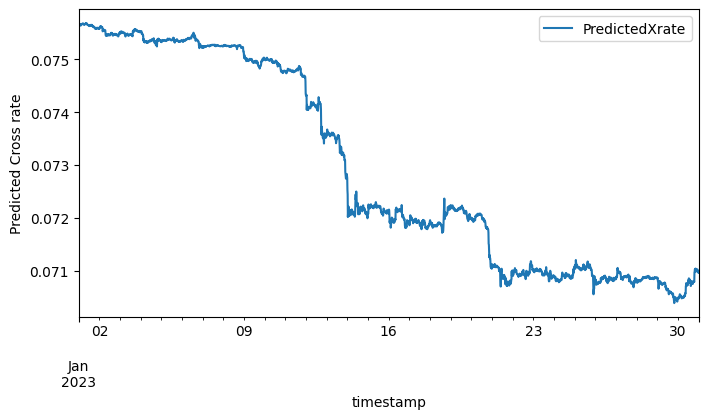

In [1605]:
cross_df.plot(figsize =(8,4))
plt.ylabel('Predicted Cross rate')

In [1606]:
#cross_df

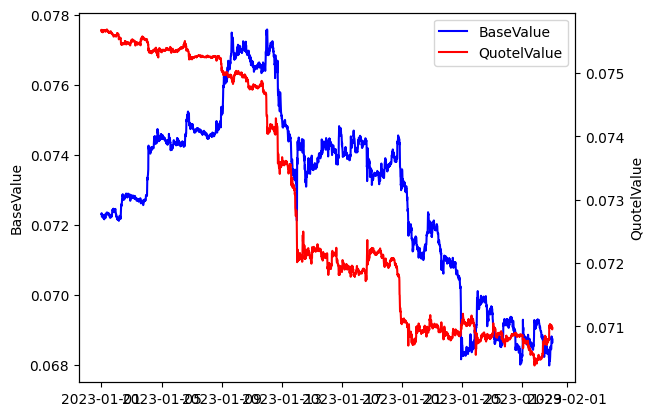

<Figure size 800x800 with 0 Axes>

In [1607]:
plot_series_pair(df['Close'], cross_df['PredictedXrate'])

In [1608]:
print(type(df['Close']), type(cross_df['PredictedXrate']))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [1609]:
def get_cross_spread(df_actual, df_predict, df_quote):
    """
    Spread between Predicted and Actual rate
    """
    print('act', len(df_actual))
    cross_df = pd.DataFrame(df_predict / df_quote['Close'], df_quote.index)
    cross_df.columns = ['PredictedXrate']
    print('@ x df', len(cross_df), cross_df.head(3))
    cross_spread_df = pd.DataFrame(df_actual['Close'] - cross_df['PredictedXrate'], df_quote.index)     
    cross_spread_df.columns = ['Spread']
    print('@@@ x df', len(cross_spread_df), cross_spread_df.head(3))
    return cross_spread_df

In [1610]:
def get_spread_range(df, ratio=1.96):
    """
    Normal distribution range
    """
    df_mean = df['Spread'].mean()
    df_std = df['Spread'].std()
    upper_bound = df_mean + ratio * df_std
    lower_bound = df_mean - ratio * df_std
    df['Mean'] = df_mean
    df['Upper'] = upper_bound
    df['Lower'] = lower_bound
    return df

In [1611]:
def linear_model_coint(df_base, df_quote):
    """
    Lenear rgression based range
    """
    lin_regression = linear_regression(df_base['Close'], df_quote['Close'])
    a = lin_regression.params.iloc[0]
    b = lin_regression.params.iloc[1]
    return a, b

In [1612]:
def cross_rate_predictior_coint(df_base, df_quote):
    a, b = linear_model_coint(df_base, df_quote)
    y_pred = a + df_quote['Close'] * b
    return y_pred

In [1613]:
def get_stat_spread(df_actual, df_base, df_quote):
    y_pred = cross_rate_predictior_coint(df_base, df_quote)
    spread_df = get_cross_spread(df_actual, y_pred, df_quote)
    spread_mean = spread_df['Spread'].mean()
    spread_std = spread_df['Spread'].std()
    return spread_df

In [1614]:
cross_spread_df = get_stat_spread(df, df_base, df_quote)

act 2881
@ x df 2881                      PredictedXrate
timestamp                          
2023-01-01 00:00:00        0.075676
2023-01-01 00:15:00        0.075652
2023-01-01 00:30:00        0.075682
@@@ x df 2881                        Spread
timestamp                    
2023-01-01 00:00:00 -0.003370
2023-01-01 00:15:00 -0.003324
2023-01-01 00:30:00 -0.003410


In [1615]:
sigma_r = 1.96

In [1616]:
cross_spread_df = get_spread_range(cross_spread_df, sigma_r)

In [1617]:
cross_spread_df

,Spread,Mean,Upper,Lower
timestamp,,,,
2023-01-01 00:00:00,-0.003370,-0.000014,0.003636,-0.003664
2023-01-01 00:15:00,-0.003324,-0.000014,0.003636,-0.003664
2023-01-01 00:30:00,-0.003410,-0.000014,0.003636,-0.003664
2023-01-01 00:45:00,-0.003433,-0.000014,0.003636,-0.003664
2023-01-01 01:00:00,-0.003379,-0.000014,0.003636,-0.003664
...,...,...,...,...
2023-01-30 23:00:00,-0.002285,-0.000014,0.003636,-0.003664
2023-01-30 23:15:00,-0.002220,-0.000014,0.003636,-0.003664
2023-01-30 23:30:00,-0.002224,-0.000014,0.003636,-0.003664


Text(0, 0.5, 'Cross Spread')

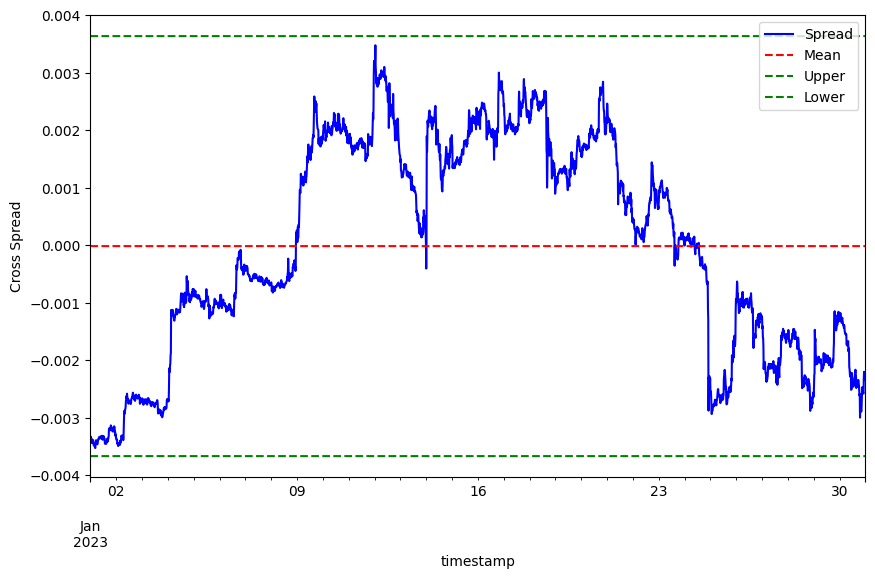

In [1618]:
cross_spread_df.plot(figsize =(10,6),style=['b', '--r', '--g', '--g'])
plt.ylabel('Cross Spread')

In [1619]:
def check_stationarity(df):
    """
    # check if the TS is stationary 
    """
    adf = sm.tsa.stattools.adfuller(df, maxlag=1)
    print('ADF test statistic: %.02f' % adf[0])
    for key, value in adf[4].items():
        print('\t%s: %.3f' % (key, value))
    print('p-value: %.03f' % adf[1])
    return adf[1]

In [1620]:
def plot_z_score(z_score, range=2.0):
    plt.figure(figsize=(8, 4))
    plt.plot(z_score)
    plt.axhline(y=range, color='r', linestyle='--')  # Upper threshold
    plt.axhline(y=range*-1, color='r', linestyle='--')  # Lower threshold
    plt.ylim(range*-1.2, range*1.2)  # Set y-axis limits from -2.5 to 2.5
    plt.xlabel('Time')
    plt.ylabel('Z-score')
    plt.title('Z-score Plot')
    plt.grid(True)
    plt.show()

In [1621]:
adf_result = check_stationarity(cross_spread_df['Spread'])

ADF test statistic: -1.82
	1%: -3.433
	5%: -2.863
	10%: -2.567
p-value: 0.370


In [1622]:
cross_spread_mean = cross_spread_df['Spread'].mean()
cross_spread_std = cross_spread_df['Spread'].std()

In [1623]:
z_score = (cross_spread_df['Spread'] - cross_spread_mean) / cross_spread_std

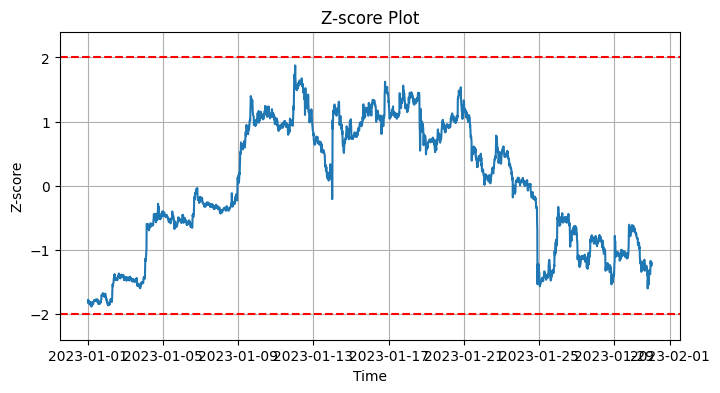

In [1624]:
plot_z_score(z_score)

In [1625]:
# APPROACH 2
# Dynamic Kalman Filter

In [1626]:
obs_mat = sm.add_constant(df_quote['Close'].values, prepend=False)[:, np.newaxis]
trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)

In [1627]:
kf = KalmanFilter(n_dim_obs=1,
                  n_dim_state=2, 
                  initial_state_mean=np.ones(2),  # Number of state variables
                  initial_state_covariance=np.ones((2, 2)),  # Initial state mean
                  transition_matrices=np.eye(2),  # Initial state covariance
                  observation_matrices=obs_mat,  # Transition matrix
                  observation_covariance=1.0,  # Observation matrix
                  transition_covariance=trans_cov)  # Transition covariance

In [1628]:
state_means, state_covs = kf.filter(df_base['Close'].values)
slope=state_means[:, 0] 
intercept=state_means[:, 1]

In [1629]:
predicted_slope, predicted_intercept = slope[-1], intercept[-1]

In [1630]:
print(predicted_slope, predicted_intercept)

0.06871589053323787 0.07229570226482199


Text(0, 0.5, 'Intercept')

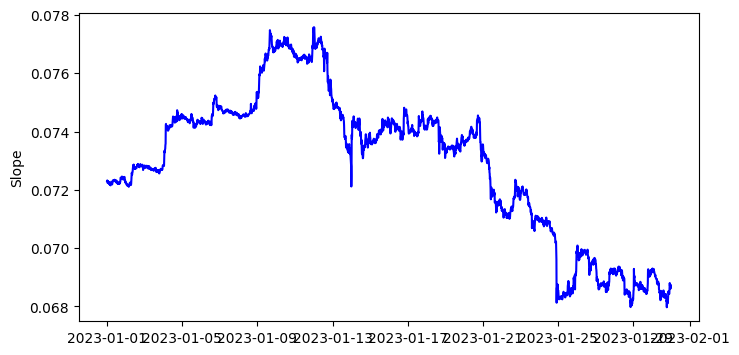

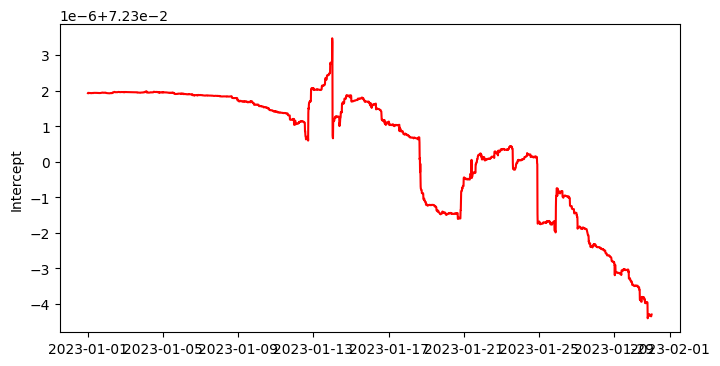

In [1631]:
plt.figure(figsize =(8,4))
plt.plot(df_base['Close'].index, slope, c='b')
plt.ylabel('Slope')
plt.figure(figsize =(8,4))
plt.plot(df_base['Close'].index,intercept,c='r')
plt.ylabel('Intercept')

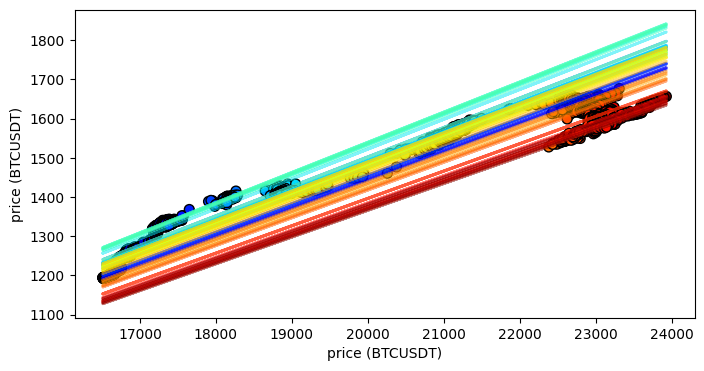

In [1632]:
plt.figure(figsize =(8,4))
cm = plt.get_cmap('jet')
sc = plt.scatter(df_quote['Close'], df_base['Close'], s=50, c=df_quote['Close'], cmap=cm, label='Price', edgecolor='k')
#cb = plt.colorbar(sc)
#cb.ax.set_yticklabels([str(p) for p in data[symbols[0]].index])
plt.xlabel("price (%s)" %symbols[0])
plt.ylabel("price (%s)" %symbols[0])

# add regression lines
step = 50 # pick slope and intercept every 50 days
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, b in enumerate(state_means[::step]):
    plt.plot(df_quote['Close'], b[0] * df_quote['Close'] + b[1], alpha=.5, lw=2, c=cm(colors_l[i]))

In [1633]:
kl_predict = df_quote['Close'] * state_means[:,0] + state_means[:,1]

In [1634]:
kl_predict.head(1)

timestamp
2023-01-01    1194.550056
Name: Close, dtype: float64

In [1635]:
#klf_pred = pd.DataFrame({'KlmSpread': kl_spread}, index=df_base.index)

Text(0, 0.5, 'Predicted Cross rate')

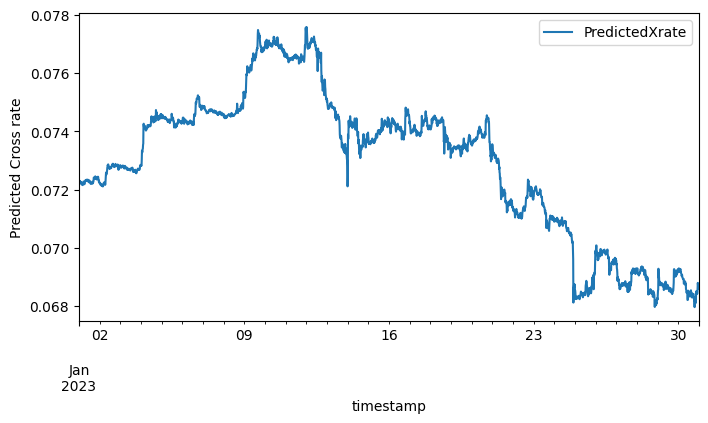

In [1636]:
klf_cross_df = pd.DataFrame(kl_predict / df_quote['Close'],df_quote.index)
klf_cross_df.columns = ['PredictedXrate']
klf_cross_df.plot(figsize =(8,4))
plt.ylabel('Predicted Cross rate')

In [1637]:
# MODELLING

In [1798]:
class SpreadModelBase():
    def __init__(self): 
       
        self.slope_df = {}
        self.intercept_df = {}
        self.slope = 0
        self.intercept = 0
        
    def get_model_params(self, df_base, df_quote):
        raise NotImplementedError("Subclasses must implement get_model_params")
        
    def apply_model_for_range(self, df):
        raise NotImplementedError("Subclasses must implement")
        
    def apply_model_for_value(self, value):
        raise NotImplementedError("Subclasses must implement")
        
    def get_cross_spread_for_range(self, df_actual, df_base, df_quote):
        """
        Compute model and get a Spread between Predicted and Actual rate
        """
        self.get_model_params(df_base, df_quote)
        df_predict = self.apply_model_for_range(df_quote)
        cross_df = pd.DataFrame(df_predict / df_quote['Close'], df_quote.index)
        cross_df.columns = ['PredictedXrate']
        #print('@ x df', len(cross_df), cross_df.head(3))
        cross_spread_df = pd.DataFrame(df_actual['Close'] - cross_df['PredictedXrate'], df_quote.index)     
        cross_spread_df.columns = ['Spread']
        #print('@@@ x df', len(cross_spread_df), cross_spread_df.head(3))
        return cross_spread_df
        
    def get_cross_spread_for_value(self, actual, base, quote):
        """
        Compute model and get a Spread between Predicted and Actual rate
        """
        print('get_cross_spread_for_value', len(df_base), len(df_quote))
        #print(ldf_base, df_quote)
        self.get_model_params(df_base, df_quote)
        predict = self.apply_model_for_value(quote)
        predicted_cross = redict / quote
        cross_spread = actual - predicted_cross   
        return cross_spread_df

    def predict_cross_spread_for_range(self, df_actual, df_quote):
        """
        Spread between Predicted and Actual rate
        """
        # parameters should be computed previously
        df_predict = self.apply_model_for_range(self, df_quote)
        cross_df = pd.DataFrame(df_predict / df_quote['Close'], df_quote.index)
        cross_df.columns = ['PredictedXrate']
        #print('@ x df', len(cross_df), cross_df.head(3))
        cross_spread_df = pd.DataFrame(df_actual['Close'] - cross_df['PredictedXrate'], df_quote.index)     
        cross_spread_df.columns = ['Spread']
        #print('@@@ x df', len(cross_spread_df), cross_spread_df.head(3))
        return cross_spread_df

    def predict_cross_spread_for_value(self, actual, quote):
        """
        Spread between Predicted and Actual rate
        """
        # parameters should be computed previously
        predict = self.apply_model_for_value(quote)
        cross = predict / quote
        #print('@ x df', len(cross_df), cross_df.head(3))
        cross_spread = actual - cross   
        #print('@@@ x df', len(cross_spread_df), cross_spread_df.head(3))
        return cross_spread
         
    def get_spread_range(self, df, ratio=1.96):
        """
        Normal distribution range
        """
        df_mean = df['Spread'].mean()
        df_std = df['Spread'].std()
        print('df_mean', df_mean, 'df_std', df_std)
        upper_bound = df_mean + ratio * df_std
        lower_bound = df_mean - ratio * df_std
        
        df['Mean'] = df_mean
        df['Upper'] = upper_bound
        df['Lower'] = lower_bound
        return df
        
    def get_spread_range_predict(self, df, value, ratio=1.96):
        """
        Normal distribution range, shift + 1
        """
        # print('init df', df.tail(3))
        new_index, new_value = value
        df = df.copy()
        df.loc[new_index] = new_value
        
        if len(df) > 1:
            df = df.iloc[1:]      
        #print('shifted df', df.tail(3))
        
        df = self.get_spread_range(df, ratio)
        return df    

In [1799]:
class CointegrationModel(SpreadModelBase):
    """
    RV trading system based on a cointegration of two timeseries
    Entry Logic: Price is outside a channel's border
    Exit Logic: Price returned to the channel's mean
    Position Management: Stop Loss, Take Profit, Breakeven
    """
    
    def get_model_params(self, df_base, df_quote):
        print('get_model_params', len(df_base), len(df_quote))
        #print(df_base, df_quote)
        lin_regression = linear_regression(df_base['Close'], df_quote['Close'])
        self.intercept = lin_regression.params.iloc[0]
        self.slope = lin_regression.params.iloc[1]
        
    def apply_model_for_range(self, df):
        # for quote to predict base
        y_pred = df['Close'] * self.slope + self.intercept
        return y_pred
        
    def apply_model_for_value(self, value):
        y_pred = value * self.slope + self.intercept
        return y_pred 

In [1800]:
class KalmanFilterModel(SpreadModelBase):
    """
    RV trading system based on a statistical range of a stationary timeseries fluctuation.
    Entry Logic: Price is outside a channel's border
    Exit Logic: Price returned to the channel's mean
    Position Management: Stop Loss, Take Profit, Breakeven
    """
    
    def get_model_params(self, df_base, df_quote):
        print('get_model_params', len(df_base), len(df_quote))
        #print(df_base, df_quote)
        obs_mat = sm.add_constant(df_quote['Close'].values, prepend=False)[:, np.newaxis]
        trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)
        kf = KalmanFilter(n_dim_obs=1,
                          n_dim_state=2, 
                          initial_state_mean=np.ones(2),  # Number of state variables
                          initial_state_covariance=np.ones((2, 2)),  # Initial state mean
                          transition_matrices=np.eye(2),  # Initial state covariance
                          observation_matrices=obs_mat,  # Transition matrix
                          observation_covariance=0.5,  # Observation matrix
                          transition_covariance=trans_cov)  # Transition covariance
        state_means, state_covs = kf.filter(df_base['Close'].values)
        self.slope_df = state_means[:, 0] 
        self.intercept_df = state_means[:, 1]
        self.slope = slope[-1]
        self.intercept = intercept[-1]
        
    def apply_model_for_range(self, df):
        # for quoteto predict base
        
        y_pred = df['Close'] * self.slope_df + self.intercept_df
        return y_pred
        
    def apply_model_for_value(self, value):
        y_pred = value * self.slope + self.intercept
        return y_pred       

In [1801]:
model = KalmanFilterModel()
klf_x_df = model.get_cross_spread_for_range(df, df_base, df_quote)
klf_x_df = model.get_spread_range(klf_x_df)

get_model_params 2881 2881
df_mean 1.4204894816532508e-07 df_std 8.575896894272662e-06


In [1642]:
klf_x_df

,Spread,Mean,Upper,Lower
timestamp,,,,
2023-01-01 00:00:00,-3.036759e-07,1.420489e-07,0.000017,-0.000017
2023-01-01 00:15:00,-1.063686e-07,1.420489e-07,0.000017,-0.000017
2023-01-01 00:30:00,-2.240699e-06,1.420489e-07,0.000017,-0.000017
2023-01-01 00:45:00,-5.198119e-06,1.420489e-07,0.000017,-0.000017
2023-01-01 01:00:00,-8.825880e-07,1.420489e-07,0.000017,-0.000017
...,...,...,...,...
2023-01-30 23:00:00,6.479907e-06,1.420489e-07,0.000017,-0.000017
2023-01-30 23:15:00,3.381452e-06,1.420489e-07,0.000017,-0.000017
2023-01-30 23:30:00,-5.264936e-06,1.420489e-07,0.000017,-0.000017


In [1643]:
def kalman_filter_predictor(df_base, df_quote):
    obs_mat = sm.add_constant(df_qquote['Close'].values, prepend=False)[:, np.newaxis]
    trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)
    kf = KalmanFilter(n_dim_obs=1,
                      n_dim_state=2, 
                      initial_state_mean=np.ones(2),  # Number of state variables
                      initial_state_covariance=np.ones((2, 2)),  # Initial state mean
                      transition_matrices=np.eye(2),  # Initial state covariance
                      observation_matrices=obs_mat,  # Transition matrix
                      observation_covariance=0.5,  # Observation matrix
                      transition_covariance=trans_cov)  # Transition covariance
    state_means, state_covs = kf.filter(df_base['Close'].values)
    slope=state_means[:, 0] 
    intercept=state_means[:, 1]
    y_pred = df_quote['Close'] * state_means[:,0] + state_means[:,1]
    predicted_slope, predicted_intercept = slope[-1], intercept[-1]
    return y_pred, predicted_intercept, predicted_slope 

In [1644]:
def model_kalman(df_actual, df_base, df_quote):
    y_pred, a, b = cross_rate_predictior_kalman(df_base, df_quote)
    print('y pred', len(y_pred), y_pred.head(3))
    print('actual', len(df_actual), df_actual.head(3))
    print('base', df_base.head(3))
    print('quote', df_quote.head(3))
    spread_df = get_spread(df_actual, y_pred, df_quote)
    print('s_df', len(spread_df), spread_df.head(3))
    return spread_df, a, b

In [1645]:
#klf_cross_spread_df

In [1646]:
klf_cross_spread_df, a, b = model_kalman(df, df_base, df_quote)

y pred 2881 timestamp
2023-01-01 00:00:00    1194.550028
2023-01-01 00:15:00    1196.609934
2023-01-01 00:30:00    1193.640163
Name: Close, dtype: float64
actual 2881                          Open      High       Low     Close    Volume
timestamp                                                            
2023-01-01 00:00:00  0.072299  0.072356  0.072299  0.072306  495.7506
2023-01-01 00:15:00  0.072306  0.072335  0.072276  0.072328  496.2642
2023-01-01 00:30:00  0.072328  0.072331  0.072247  0.072272  635.8680
base                         Open     High      Low    Close     Volume
timestamp                                                         
2023-01-01 00:00:00  1196.13  1196.69  1194.55  1194.55  1245.8855
2023-01-01 00:15:00  1194.55  1196.70  1194.31  1196.61  1141.6075
2023-01-01 00:30:00  1196.62  1196.62  1192.72  1193.64  2206.9409
quote                          Open      High       Low     Close      Volume
timestamp                                                        

In [1647]:
#klf_cross_spread_df = get_spread_range(klf_cross_spread_df)

In [1648]:
#klf_cross_spread_df

In [1649]:
adf_result = check_stationarity(klf_cross_spread_df['Spread'])

ADF test statistic: -50.77
	1%: -3.433
	5%: -2.863
	10%: -2.567
p-value: 0.000


In [1650]:
#Probability, %	99,99	99,90	99,00	97,72	97,50	95,00	90,00	84,13	50,00
#Quantile   	3,719	3,09	2,326	1,999	1,96	1,645	1,282	1	     0

In [1651]:
sigma_r = 1.96

In [1652]:
klf_cross_spread_df = get_spread_range(klf_cross_spread_df, sigma_r)

Text(0, 0.5, 'Cross Spread')

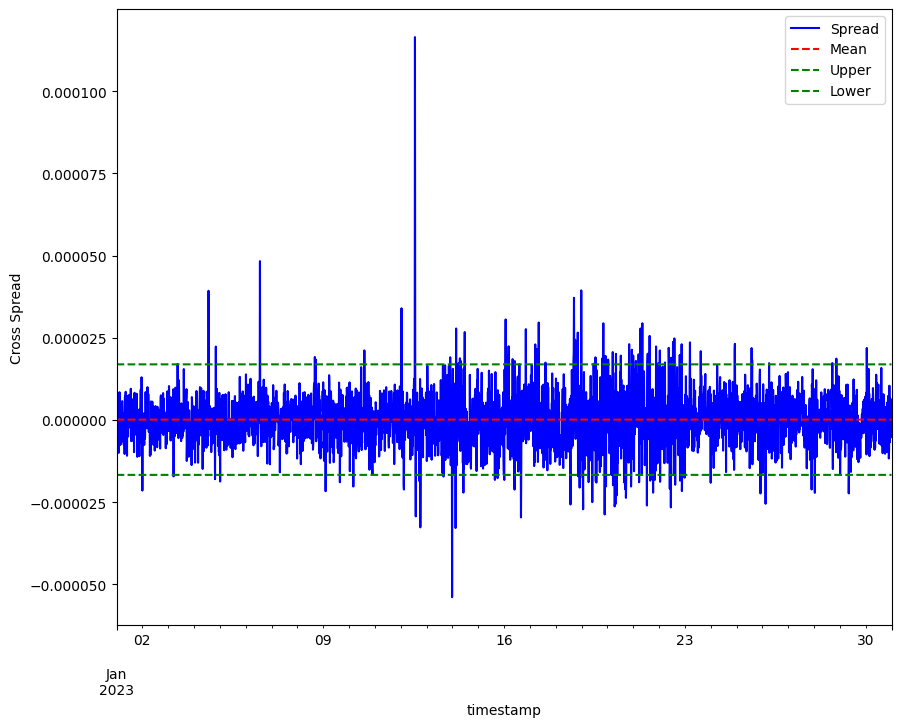

In [1653]:
klf_cross_spread_df.plot(figsize =(10,8),style=['b', '--r', '--g', '--g'])
plt.ylabel('Cross Spread')

In [1654]:
adf_result = check_stationarity(klf_cross_spread_df['Spread'])

ADF test statistic: -50.77
	1%: -3.433
	5%: -2.863
	10%: -2.567
p-value: 0.000


In [1655]:
klf_cross_spread_mean = klf_cross_spread_df['Spread'].mean()
klf_cross_spread_std = klf_cross_spread_df['Spread'].std()

In [1656]:
z_score = (klf_cross_spread_df['Spread'] - klf_cross_spread_mean) / klf_cross_spread_std

In [1657]:
print(type(z_score))

<class 'pandas.core.series.Series'>


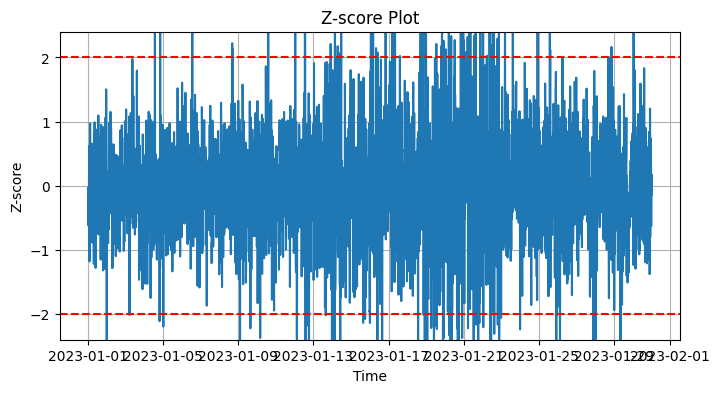

In [1658]:
plot_z_score(z_score, 2)

In [1659]:
klf_cross_spread_df.head(3)

,Spread,Mean,Upper,Lower
timestamp,,,,
2023-01-01 00:00:00,-3.036759e-07,1.420489e-07,0.000017,-0.000017
2023-01-01 00:15:00,-1.063686e-07,1.420489e-07,0.000017,-0.000017
2023-01-01 00:30:00,-2.240699e-06,1.420489e-07,0.000017,-0.000017


In [1660]:
def z_score_kalman(df):
    spread_df = get_spread_range(df)
    spread_mean = spread_df['Spread'].mean()
    spread_std = spread_df['Spread'].std()
    #z_score = (spread_df['Spread'] - spread_mean) / spread_std
    #spread_df['ZScore'] = z_score
    return spread_df
    #return pd.DataFrame({'FairValue': fair_value, 'Spread': spread})     

In [1713]:
#output_path = r'C:/Users/Administrator/Documents/PythonAnalytics/'
#result_df.to_csv(f"{output_path}.{symbol}.Model.csv", sep=',')

In [1663]:
model_type = 1
enter_on_mean = False
sigma_r = 1.96 #3.09
if model_type == 0:
    spread_df, a, b = model_coint(df, df_base, df_quote)   
elif model_type == 1:    
    spread_df, a, b = model_kalman(df, df_base, df_quote)   
spread_df = get_spread_range(spread_df, sigma_r)
work_df = spread_df.copy()

y pred 2881 timestamp
2023-01-01 00:00:00    1194.550028
2023-01-01 00:15:00    1196.609934
2023-01-01 00:30:00    1193.640163
Name: Close, dtype: float64
actual 2881                          Open      High       Low     Close    Volume
timestamp                                                            
2023-01-01 00:00:00  0.072299  0.072356  0.072299  0.072306  495.7506
2023-01-01 00:15:00  0.072306  0.072335  0.072276  0.072328  496.2642
2023-01-01 00:30:00  0.072328  0.072331  0.072247  0.072272  635.8680
base                         Open     High      Low    Close     Volume
timestamp                                                         
2023-01-01 00:00:00  1196.13  1196.69  1194.55  1194.55  1245.8855
2023-01-01 00:15:00  1194.55  1196.70  1194.31  1196.61  1141.6075
2023-01-01 00:30:00  1196.62  1196.62  1192.72  1193.64  2206.9409
quote                          Open      High       Low     Close      Volume
timestamp                                                        

In [1664]:
work_df['Buy'] = work_df['Spread'][((work_df['Spread'] < work_df['Lower']) & (work_df['Spread'].shift(1) > work_df['Lower']) | 
                          (enter_on_mean) & (work_df['Spread'] <  work_df['Mean']) & (work_df['Spread'].shift(1) >  work_df['Mean']))]
work_df['Sell'] = work_df['Spread'][((work_df['Spread'] > work_df['Upper']) & (work_df['Spread'].shift(1) < work_df['Upper']) | 
                          (enter_on_mean) & (work_df['Spread'] >  work_df['Mean']) & (work_df['Spread'].shift(1) <  work_df['Mean']))]


<Axes: xlabel='timestamp'>

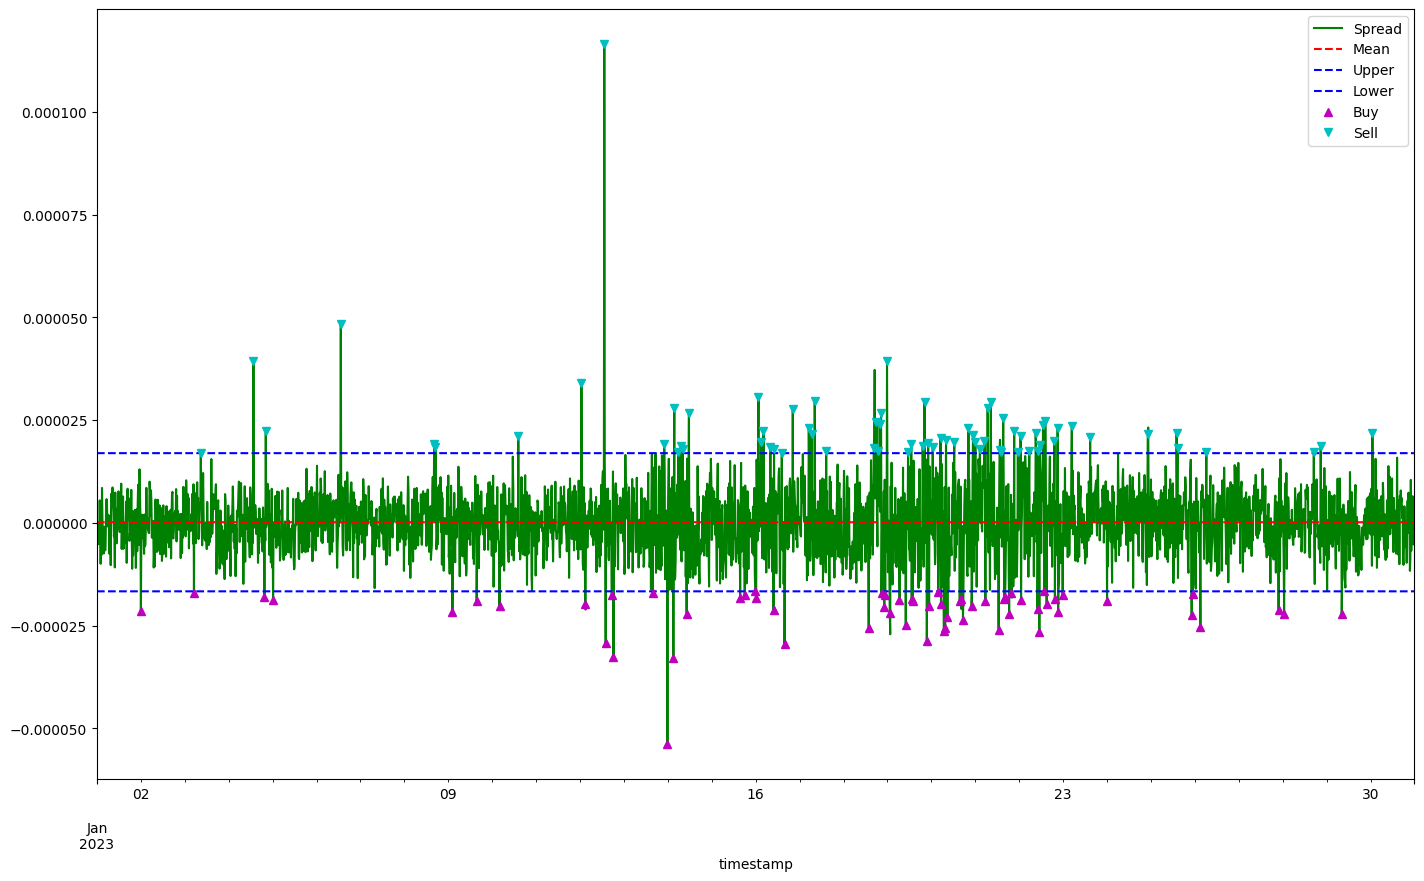

In [1665]:
work_df.plot(figsize =(17,10), style=['g', '--r', '--b', '--b', 'm^','cv'])

In [1666]:
work_df['SellEx'] = work_df['Spread'][((work_df['Spread'] < work_df['Lower']) & (work_df['Spread'].shift(1) > work_df['Lower']) | 
                          (enter_on_mean) & (work_df['Spread'] <  work_df['Mean']) & (work_df['Spread'].shift(1) >  work_df['Mean']))]
work_df['BuyEx'] = work_df['Spread'][((work_df['Spread'] > work_df['Upper']) & (work_df['Spread'].shift(1) < work_df['Upper']) | 
                          (enter_on_mean) & (work_df['Spread'] >  work_df['Mean']) & (work_df['Spread'].shift(1) <  work_df['Mean']))]

In [1667]:
mask = ['Buy', 'Sell', 'BuyEx', 'SellEx']

In [1668]:
work_df[mask] = work_df[mask].fillna(0)

work_df.loc[:, mask] = work_df[mask].apply(lambda x: x.map(lambda y: 1 if y != 0 else 0))

In [1669]:
work_df = pd.merge(df_base['Close'], work_df, left_index=True, right_index=True, how='left')

In [1670]:
work_df.head(3)

,Close,Spread,Mean,Upper,Lower,Buy,Sell,SellEx,BuyEx
timestamp,,,,,,,,,
2023-01-01 00:00:00,1194.55,-3.036759e-07,1.420489e-07,0.000017,-0.000017,0.0,0.0,0.0,0.0
2023-01-01 00:15:00,1196.61,-1.063686e-07,1.420489e-07,0.000017,-0.000017,0.0,0.0,0.0,0.0
2023-01-01 00:30:00,1193.64,-2.240699e-06,1.420489e-07,0.000017,-0.000017,0.0,0.0,0.0,0.0


In [1671]:
work_df['Buy'].sum()

62.0

In [1672]:
def get_stat_spread_triggers(df, work_df):
    """
    Computes Entry and Exit triggers
    Returns a DataFrame with Close Price and Entry and Close Triggers
    """
    work_df['Buy'] = work_df['Spread'][((work_df['Spread'] < work_df['Lower']) & (work_df['Spread'].shift(1) > work_df['Lower']) | 
                          (enter_on_mean) & (work_df['Spread'] <  work_df['Mean']) & (work_df['Spread'].shift(1) >  work_df['Mean']))]
    work_df['Sell'] = work_df['Spread'][((work_df['Spread'] > work_df['Upper']) & (work_df['Spread'].shift(1) < work_df['Upper']) | 
                          (enter_on_mean) & (work_df['Spread'] >  work_df['Mean']) & (work_df['Spread'].shift(1) <  work_df['Mean']))]
    work_df['SellEx'] = work_df['Spread'][((work_df['Spread'] < work_df['Lower']) & (work_df['Spread'].shift(1) > work_df['Lower']) | 
                          (enter_on_mean) & (work_df['Spread'] <  work_df['Mean']) & (work_df['Spread'].shift(1) >  work_df['Mean']))]
    work_df['BuyEx'] = work_df['Spread'][((work_df['Spread'] > work_df['Upper']) & (work_df['Spread'].shift(1) < work_df['Upper']) | 
                          (enter_on_mean) & (work_df['Spread'] >  work_df['Mean']) & (work_df['Spread'].shift(1) <  work_df['Mean']))]

    mask = ['Buy', 'Sell', 'BuyEx', 'SellEx']
    work_df[mask] = work_df[mask].fillna(0)
    # Set 1 for Buy and -1 for Sell
    work_df.loc[:, mask] = work_df[mask].apply(lambda x: x.map(lambda y: -1 if 'Sell' in x.name else (1 if y != 0 else 0)))
    entry_mask = ['Buy', 'Sell']
    work_df['EntryTrigger'] = (work_df[entry_mask] != 0).any(axis=1).astype(int)
    exit_mask = ['BuyEx', 'SellEx']
    work_df['ExitTrigger'] = (work_df[exit_mask] != 0).any(axis=1).astype(int)
    
    res_df = pd.merge(df['Close'], work_df, left_index=True, right_index=True, how='left')
    return res_df

In [1802]:
class StatisticalChannelRVStrategy():
    """
    RV trading system based on a statistical range of a stationary timeseries fluctuation.
    Entry Logic: Price is outside a channel's border
    Exit Logic: Price returned to the channel's mean
    Position Management: Stop Loss, Take Profit, Breakeven
    """
    # Logic
    
    # Input parameters for the Spread
    def __init__(self, model, df, df_base, df_quote): 
        self.model = model
        
        self.df = df
        self.df_base = df_base
        self.df_quote = df_quote
        self.spread_df = {}
        self.index_list = self.df.index.tolist()

        self.positions = []
        
        # Exit trigger
        self.exit_trig_is_on = 1
        
        # stop_loss
        self.stop_loss_is_on = 0
        # Extremum search lookback
        self.stop_loss_lookback = 4
        self.stop_loss_pct = 0.0

        self.position = 0
        
        # Break even from Entry price
        self.break_even_is_on = 0
        self.break_even_pct = 0.001
        
        # Dynamic TP
        self.profit_target_is_on = 0
        self.profit_target_dyn_ratio = 1
    
        self.stop_loss = 0
        self.profit_target = 0
        self.be_level = 0
        self.entry_price = 0
        
        self.model_type = 1
        self.enter_on_mean = False

        self.adf_barrier = 0.05
        self.adjust_model = False

        self.spread = 0
        self.sigma_r = 1.96 #3.09

        self.lookback = 672
        self.step = 96
        self.train_period_ratio = 0.7
        self.df_len = len(df)

        self.entry_time = None
        self.trades_num = 0
        self.balance = 1000
        self.commission = 0.001
        self.cum_pnl = 0
        self.results_df = pd.DataFrame(columns=['Id', 'EntryTime', 'ExitTime', 'Volume', 'PnL', 'CumPnL'])

    def get_size(self, balance, cum_pnl, price):
        return (balance + cum_pnl) / float(price)

    def on_bar(self, i):
        print('#', i, self.position, self.cum_pnl)
        # print(len(self.df), df.head())
        # A Position is opened

        close = self.df['Close'].iloc[i]
        prev_close = self.df['Close'].iloc[i-1]
        
        #base = self.base_df['Close'].iloc[i]
        quote = self.df_quote['Close'].iloc[i]

        # current spread
        
        #spread_df_len = len(self.spread_df['Spread'])
        # predicted spred for current bar
        spread = self.model.predict_cross_spread_for_value(close, quote)    
        prev_spread = self.spread_df['Spread'].iloc[-1]
        #spread_mean += (spread - spread_mean) / float(len(self.spread_df['Spread']))        
        # spread normal distribution range (channel) 
        value = (self.index_list[i], spread)
        log('last value', value)
        
        # spread dataframe with predicted values and channel
        self.spread_df = self.model.get_spread_range_predict(self.spread_df, value, self.sigma_r)
        
        log('bar spread', spread, '->', self.spread_df['Spread'].mean(),  self.spread_df['Spread'].std(), close, quote)
        log('bar_range', self.spread_df.tail(3))
        
        long_entry_trigger = spread > self.spread_df['Upper'].iloc[-1] and prev_spread < self.spread_df['Upper'].iloc[-1]
        short_entry_trigger = spread < self.spread_df['Lower'].iloc[-1] and prev_spread > self.spread_df['Lower'].iloc[-1]

        log('long trig', long_entry_trigger, 'spread', spread, 'prev', prev_spread, self.spread_df['Upper'].iloc[-1])
        log('short trig', short_entry_trigger, 'spread', spread, 'prev', prev_spread, self.spread_df['Lower'].iloc[-1])
        
        short_exit_trigger = spread > self.spread_df['Upper'].iloc[-1] and prev_spread < self.spread_df['Upper'].iloc[-1]
        long_exit_trigger = spread < self.spread_df['Lower'].iloc[-1] and prev_spread > self.spread_df['Lower'].iloc[-1]
        
        if self.position != 0:
            # log(self.position)
            # Check Exit triggers
            exit_trigger = False
            sign = 1 if self.position > 0 else -1
            side = 'long' if self.position > 0 else 'short'
            # Check Exit trigger
            exit_trigger = long_exit_trigger and sign == 1 or \
                    short_exit_trigger and sign == -1 or \
                    self.stop_loss > 0 and (close - self.stop_loss) * sign < 0  or \
                    self.profit_target > 0 and (close - self.profit_target) * sign > 0            
            if exit_trigger:
                log(side, 'close trigger: spread', self.spread_df['Spread'].iloc[-1], close)
                # Exit action
                pnl = self.position * (close - self.entry_price) * (1 - self.commission) * sign
                
                self.cum_pnl += pnl
                self.trades_num += 1
                self.results_df = pd.DataFrame(columns=['Id', 'EntryTime', 'ExitTime', 'Volume', 'PnL', 'CumPnL'])
                self.results_df \
                = pd.concat([self.results_df, pd.DataFrame([{'Id': self.trades_num,
                                                             'EntryTime': self.entry_time,
                                                             'ExitTime': self.index_list[i].replace(tzinfo=None),
                                                             'Volume': self.position,
                                                             'PnL': pnl,
                                                             'CumPnL': self.cum_pnl,
                                                            }])],
                                                            ignore_index=True)
                log('close the position #', self.trades_num, ':', 'pnl', pnl, 'vol', self.position, self.index_list[i], close)
                log('-' * 90)
                
            # Check Breakeven trigger
            elif self.break_even_is_on == 1 and self.be_level == 0:                
                thresh = self.entry_price * (1 + self.break_even_pct * sign)
                if (close - thresh) * sign > 0:
                    self.be_level = thresh   
                    self.stop_loss = thresh    
                log('be level:', self.index_list[i], self.entry_price, self.break_even_pct, '->', thresh, close)                 
        # Is Flat
        #log('pos', self.position)
        if self.position == 0:
            entry_trigger = long_entry_trigger or short_entry_trigger and sign == -1
            if entry_trigger:
                # size
                volume = self.get_size(self.balance, self.cum_pnl, close)
                
                self.position = volume
                # log('position is flat')
                self.entry_price = close
                self.entry_time = self.index_list[i].replace(tzinfo=None)
                self.be_level = 0
                sign = 1 if self.position > 0 else -1
                side = 'long' if self.position > 0 else 'short'
                # Long trigger
                if self.position > 0:                                        
                    # Set initial Stop Loss and Profit Target
                    if self.stop_loss_is_on == 1:
                        min_level = pd.Series(df['Close']).rolling(window=self.stop_loss_lookback).min().iloc[i]
                        #log(min_level)                 
                        self.stop_loss = min_level * (1 - self.stop_loss_pct)                   
                    #log('sl', self.stop_loss)
                    if self.profit_target_is_on == 1 and self.stop_loss > 0:
                        self.profit_target = self.entry_price + abs(self.entry_price - self.stop_loss) * self.profit_target_dyn_ratio
                    log(f'intial sl {self.stop_loss} and tp {self.profit_target}')
                # Short trigger
                elif self.position < 0:                
                     # Set initial Stop Loss and Profit Target
                    if self.stop_loss_is_on == 1:
                        max_level = pd.Series(self.df['Close']).rolling(window=self.stop_loss_lookback).max().iloc[i]
                        #log(max_level)
                        self.stop_loss = max_level * (1 + self.stop_loss_pct)
                        #log('sl', self.stop_loss)
                
                if self.profit_target_is_on == 1 and self.stop_loss > 0:
                        self.profit_target = self.entry_price + abs(self.entry_price - self.stop_loss) * sign * self.profit_target_dyn_ratio
                
                log('>', side, 'trigger', df['Close'], 'c', self.df['Close'].iloc[i], 'price', self.entry_price, 'size', self.position)   
                log(f'intial sl {self.stop_loss} and tp {self.profit_target}')
    
    def run(self): 
        train_period = int(min(self.lookback, self.df_len) * self.train_period_ratio)
        trade_period = min(self.lookback, self.df_len) - train_period
        t = 0
        prev_idx = t
        end_idx = min(prev_idx + self.lookback, self.df_len)
        log('df len', len(self.df), 'lookback', self.lookback, 'train', train_period, 'trade', trade_period)      
        while prev_idx < end_idx:                     
            if t < train_period:
                t += 1
                continue
            if t >= end_idx:
                break 
            # rolling window
            log('iteration', t, self.df['Close'].iloc[t], 'start idx', prev_idx, 'end_idx', end_idx)
            work_df = self.df.iloc[t-train_period:t]
            #log('work_df', len(work_df), work_df.tail(3))
            work_df_base = self.df_base.iloc[t-train_period:t]
            #log('work_df_base', len(work_df_base), work_df_base.tail(3))
            work_df_quote = self.df_quote.iloc[t-train_period:t]
            #log('work_df_quote', len(work_df_quote), work_df_quote.tail(3))
            # model
            log('Try get a training range spread')
            self.spread_df = self.model.get_cross_spread_for_range(work_df, work_df_base, work_df_quote)   
            log('model', self.model.intercept, self.model.slope)
            log('res sdf', len(self.spread_df), self.spread_df.head(3))
            adf_result = check_stationarity(self.spread_df['Spread'])
            log('adf_result', adf_result)
            # check stationarity
            if adf_result < self.adf_barrier:
                # run trading loop
                while t < end_idx:
                    iteration_res = self.on_bar(t)
                    t += 1
            else:
                t += self.step
                #if position != 0:
                #    position = 0
            prev_idx = max(0, t - train_period)
            if prev_idx >= self.df_len:
                break
            end_idx = min(prev_idx + self.lookback + 1, self.df_len)                   
            
                        # close position
    """   
            iteration_res = value
        # array of Entry triggers
                    trigger_indices = sorted(self.work_df.index[work_df['Trigger'] != 0].unique())
                    logic_indices = sorted(self.work_df.index.unique())
        #for time in sorted(self.work_df['Trigger'].index.unique()):

        

        for trigger_index in trigger_indices:
            
            
            for time in logic_indices[logic_indices >= trigger_index]:
                cur_bar = self.work_df.loc[time]
    """
# ======================================================================================================


In [1803]:
model = CointegrationModel()
#model = KalmanFilterModel()

In [1804]:
strategy = StatisticalChannelRVStrategy(model, df, df_base, df_quote)

In [1805]:
result = strategy.run()

df len 2881 lookback 672 train 470 trade 202
iteration 470 0.074335 start idx 0 end_idx 672
Try get a training range spread
get_model_params 470 470
model -2054.3875401284577 0.19611356566840626
res sdf 470                        Spread
timestamp                    
2023-01-01 00:00:00  0.000545
2023-01-01 00:15:00  0.000390
2023-01-01 00:30:00  0.000550
ADF test statistic: -3.15
	1%: -3.444
	5%: -2.868
	10%: -2.570
p-value: 0.023
adf_result 0.02299482060591523
# 470 0 0
last value (Timestamp('2023-01-05 21:30:00'), 0.00019225948184410646)
df_mean -1.19268708869183e-06 df_std 0.0003727770736278881
bar spread 0.00019225948184410646 -> -1.19268708869183e-06 0.0003727770736278881 0.074335 16843.27
bar_range                        Spread      Mean     Upper     Lower
timestamp                                                  
2023-01-05 21:00:00  0.000075 -0.000001  0.000729 -0.000732
2023-01-05 21:15:00  0.000214 -0.000001  0.000729 -0.000732
2023-01-05 21:30:00  0.000192 -0.000001  0.000

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_23352\1666447875.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  = pd.concat([self.results_df, pd.DataFrame([{'Id': self.trades_num,
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_23352\1666447875.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  = pd.concat([self.results_df, pd.DataFrame([{'Id': self.trades_num,
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_23352\1666447875.py:127: FutureWarning: The behavior of Data

close the position # 1 : pnl -14.145037551481835 vol 13459.312498317586 2023-01-18 16:15:00 0.073246
------------------------------------------------------------------------------------------
# 1698 13459.312498317586 -14.145037551481835
last value (Timestamp('2023-01-18 16:30:00'), -0.0004817397491806985)
df_mean -2.8995589471353864e-06 df_std 0.0003691039979585924
bar spread -0.0004817397491806985 -> -2.8995589471353864e-06 0.0003691039979585924 0.073572 20490.95
bar_range                        Spread      Mean     Upper     Lower
timestamp                                                  
2023-01-18 16:00:00 -0.000364 -0.000003  0.000721 -0.000726
2023-01-18 16:15:00 -0.000808 -0.000003  0.000721 -0.000726
2023-01-18 16:30:00 -0.000482 -0.000003  0.000721 -0.000726
long trig False spread -0.0004817397491806985 prev -0.000807676773920532 0.0007205442770517057
short trig False spread -0.0004817397491806985 prev -0.000807676773920532 -0.0007263433949459766
# 1699 13459.312498317586 -1

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_23352\1666447875.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  = pd.concat([self.results_df, pd.DataFrame([{'Id': self.trades_num,
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_23352\1666447875.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  = pd.concat([self.results_df, pd.DataFrame([{'Id': self.trades_num,
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_23352\1666447875.py:127: FutureWarning: The behavior of Data

df_mean -6.445304144662921e-05 df_std 0.0003740832037320996
bar spread -0.00035452283705281196 -> -6.445304144662921e-05 0.0003740832037320996 0.073699 21123.72
bar_range                        Spread      Mean     Upper     Lower
timestamp                                                  
2023-01-20 03:45:00 -0.000353 -0.000064  0.000669 -0.000798
2023-01-20 04:00:00 -0.000340 -0.000064  0.000669 -0.000798
2023-01-20 04:15:00 -0.000355 -0.000064  0.000669 -0.000798
long trig False spread -0.00035452283705281196 prev -0.00033953057687308164 0.000668750037868286
short trig False spread -0.00035452283705281196 prev -0.00033953057687308164 -0.0007976561207615444
# 1842 13459.312498317586 -109.03242348380853
last value (Timestamp('2023-01-20 04:30:00'), -0.00037755166879886726)
df_mean -6.440171621465193e-05 df_std 0.0003740384895646381
bar spread -0.00037755166879886726 -> -6.440171621465193e-05 0.0003740384895646381 0.073676 21037.37
bar_range                        Spread      Mean     

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_23352\1666447875.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  = pd.concat([self.results_df, pd.DataFrame([{'Id': self.trades_num,
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_23352\1666447875.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  = pd.concat([self.results_df, pd.DataFrame([{'Id': self.trades_num,


df_mean -5.6895231268575135e-05 df_std 0.0002665215649824611
bar spread -0.0012281545782628633 -> -5.6895231268575135e-05 0.0002665215649824611 0.073921 22104.94
bar_range                        Spread      Mean     Upper     Lower
timestamp                                                  
2023-01-20 20:00:00 -0.000593 -0.000057  0.000465 -0.000579
2023-01-20 20:15:00 -0.000579 -0.000057  0.000465 -0.000579
2023-01-20 20:30:00 -0.001228 -0.000057  0.000465 -0.000579
long trig False spread -0.0012281545782628633 prev -0.0005789818714248274 0.0004654870360970486
short trig True spread -0.0012281545782628633 prev -0.0005789818714248274 -0.0005792774986341988
long close trigger: spread -0.0012281545782628633 0.073921
close the position # 10 : pnl -5.069086651053896 vol 13459.312498317586 2023-01-20 20:30:00 0.073921
------------------------------------------------------------------------------------------
# 1907 13459.312498317586 -114.1284018412341
last value (Timestamp('2023-01-20 20:45

In [ ]:
log_depth = 1000

In [1715]:
output_path = r'C:/Users/Administrator/Documents/PythonAnalytics/'
#df.head(log_depth).to_csv(f"{output_path}.{symbol}.df.csv", sep=',')
#df_base.head(log_depth).to_csv(f"{output_path}.{symbol}.df_base.csv", sep=',')
#df_quote.head(log_depth).to_csv(f"{output_path}.{symbol}.df_qoute.csv", sep=',')